In [ ]:
from sklearn.ensemble import VotingClassifier
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE

# Ensembl models using SVC, LR and kNN models (pre XGboost)

In [4]:
with open('svc.pickle', 'rb') as read_file:
    svc = pickle.load(read_file)

with open('knn.pickle', 'rb') as read_file:
    knn = pickle.load(read_file)

with open('multinomial_nb.pickle', 'rb') as read_file:
    nb = pickle.load(read_file)

with open('logistic_regression.pickle', 'rb') as read_file:
    lr = pickle.load(read_file)
    
with open('gbm.pickle', 'rb') as read_file:
    gbm = pickle.load(read_file)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at 

In [105]:
model_names=['svc','knn','lr']

In [106]:
model_vars = [svc, knn, lr]

In [107]:
model_list=list(zip(model_names,model_vars))

In [108]:
model_list

[('svc', SVC(C=0.1, class_weight='balanced', probability=True)),
 ('knn', KNeighborsClassifier(n_neighbors=4, weights='distance')),
 ('lr',
  LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=1, max_iter=500,
                     penalty='elasticnet', solver='saga'))]

## Max Voting Classifier

Because of naive bayes not taking negative values, and other classifiers needing scaled values, which are scaled to have a mean of 0, I am going to drop NB from the ensembl 

In [110]:
skf = StratifiedKFold(n_splits=3)
train_index, test_index = next(iter(skf.split(X_train_scaled, y_train)))
X_train_cv1 = X_train_scaled[train_index]
X_validate_cv1 = X_train_scaled[test_index]
y_validate_cv1 = y_train.iloc[test_index]
y_train_cv1 = y_train.iloc[train_index]

Trying the training with an ADASYN oversampled training set

In [67]:
X_adasyn_cv1, y_adasyn_cv1 = ADASYN(random_state=42).fit_sample(X_train_cv1,y_train_cv1)

NameError: name 'ADASYN' is not defined

In [116]:
adasyn_voting_classifier = VotingClassifier(estimators=model_list,
                                    voting='hard', 
                                    n_jobs=-1)
adasyn_voting_classifier.fit(X_adasyn_cv1, y_adasyn_cv1)

VotingClassifier(estimators=[('svc',
                              SVC(C=0.1, class_weight='balanced',
                                  probability=True)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1)

In [117]:
preds=adasyn_voting_classifier.predict(X_validate_cv1)

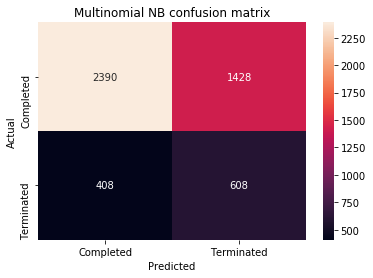

In [118]:
confusion = confusion_matrix(y_validate_cv1, preds)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multinomial NB confusion matrix'); 
#Title is wrong, this is MAX VOTING TRAINED ON ADASYN data

In [119]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.85      0.63      0.72      3818
  Terminated       0.30      0.60      0.40      1016

    accuracy                           0.62      4834
   macro avg       0.58      0.61      0.56      4834
weighted avg       0.74      0.62      0.65      4834



I'm assuming if I used my pickeled models I can just take the mode of their votes and get the similar scores 

In [129]:
svc_pred = svc.predict(X_validate_cv1)
lr_pred = lr.predict(X_validate_cv1)
knn_pred = knn.predict(X_validate_cv1)

In [137]:
combo = np.array([np.array(lr_pred),np.array(svc_pred),np.array(knn_pred)])

In [157]:
combo = np.array([np.array(lr_pred),np.array(svc_pred),np.array(knn_pred)])
preds = []
for i in range(len(y_validate_cv1)):
    counts = Counter(combo[:,i])
    pred = counts.most_common()
    preds.append(pred[0][0])

In [159]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.98      0.29      0.45      3818
  Terminated       0.27      0.98      0.42      1016

    accuracy                           0.44      4834
   macro avg       0.63      0.64      0.44      4834
weighted avg       0.83      0.44      0.45      4834



This is actually performing too well because the validation cases were part of the training cases....

I am not sure yet how to incorporate the lower threshold for SVC into this voting classifier as well

## A classifier based on average predicted probability

In [121]:
average_voting_classifier = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    n_jobs=-1)
average_voting_classifier.fit(X_adasyn_cv1, y_adasyn_cv1)

VotingClassifier(estimators=[('svc',
                              SVC(C=0.1, class_weight='balanced',
                                  probability=True)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1, voting='soft')

In [122]:
preds=average_voting_classifier.predict(X_validate_cv1)

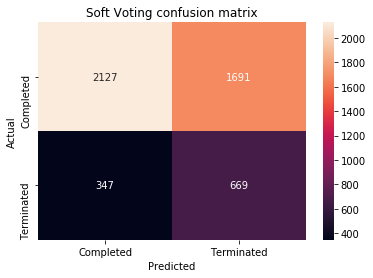

In [123]:
confusion = confusion_matrix(y_validate_cv1, preds)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting confusion matrix');

In [188]:
(669+2127)/(669+347+1691+2127) #accuracy

0.5784029788994621

In [189]:
(669)/(669+1691) #PPV / Terminated Precision

0.28347457627118644

In [192]:
(2127)/(347+2127) #NPV / Complemented Precision

0.8597413096200485

In [124]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.86      0.56      0.68      3818
  Terminated       0.28      0.66      0.40      1016

    accuracy                           0.58      4834
   macro avg       0.57      0.61      0.54      4834
weighted avg       0.74      0.58      0.62      4834



In [15]:
y_validate_01 = []
for i in y_validate_cv1:
    if i=='Completed':
        y_validate_01.append(0)
    if i=="Terminated":
        y_validate_01.append(1)

In [126]:
F1_list = []
# Will take some time
for i in np.arange(0,1,0.1):
    preds = average_voting_classifier.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

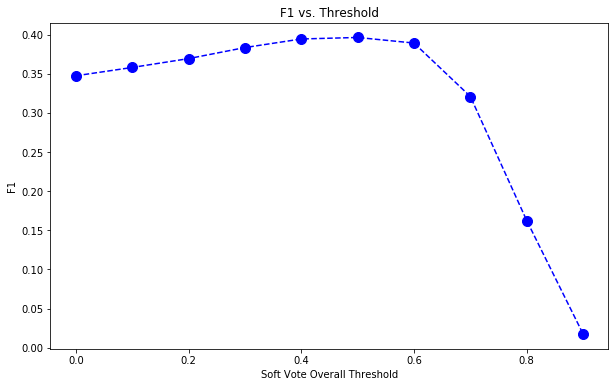

In [128]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.1), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("Soft Vote Overall Threshold")
plt.ylabel("F1")

In [129]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, average_voting_classifier.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

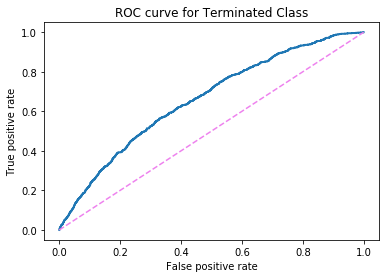

In [130]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [210]:
thresholds[np.argmax(tpr - fpr)]

0.47704091945743804

It would make sense if weights could be added to the predict call, so I don't have to keep training these models.. GridSearch is too slow for this

# Visualizing correctly called Terminated datapoints in each model

In [131]:
X_validate_term = X_validate_cv1[y_validate_cv1=='Terminated']

In [155]:
lr = lr.fit(X_train_cv1, y_train_cv1)

In [156]:
preds = lr.predict(X_validate_term)

In [167]:
correct_lr = list(preds == "Terminated")

In [169]:
knn = knn.fit(X_adasyn_cv1, y_adasyn_cv1)

In [170]:
preds_knn = knn.predict(X_validate_term)

In [171]:
correct_knn = list(preds_knn == "Terminated")

In [173]:
svc = svc.fit(X_train_cv1, y_train_cv1)

In [183]:
preds_svc = svc.predict_proba(X_validate_term)[:,1] > 0.24

In [185]:
correct_svc = list(preds_svc == 1)

In [197]:
preds_svc_term = []
for i in preds_svc:
    if i==1:
        preds_svc_term.append('Terminated')
    else:
        preds_svc_term.append('Completed')

In [199]:
#the overlap between svc and lr predictions on terminated datapoints (out of 1016)
(preds_svc_term==preds).sum()

808

In [181]:
#the overlap between knn and lr predictions on terminated datapoints (out of 1016)
(preds_knn==preds).sum()

651

In [200]:
#the overlap between svc and knn predictions on terminated datapoints (out of 1016)
(preds_svc_term==preds_knn).sum()

603

In [182]:
len(preds_svc)

1016

In [221]:
preds_soft=average_voting_classifier.predict(X_validate_term)

In [224]:
correct_soft = list(preds_soft == 'Terminated')

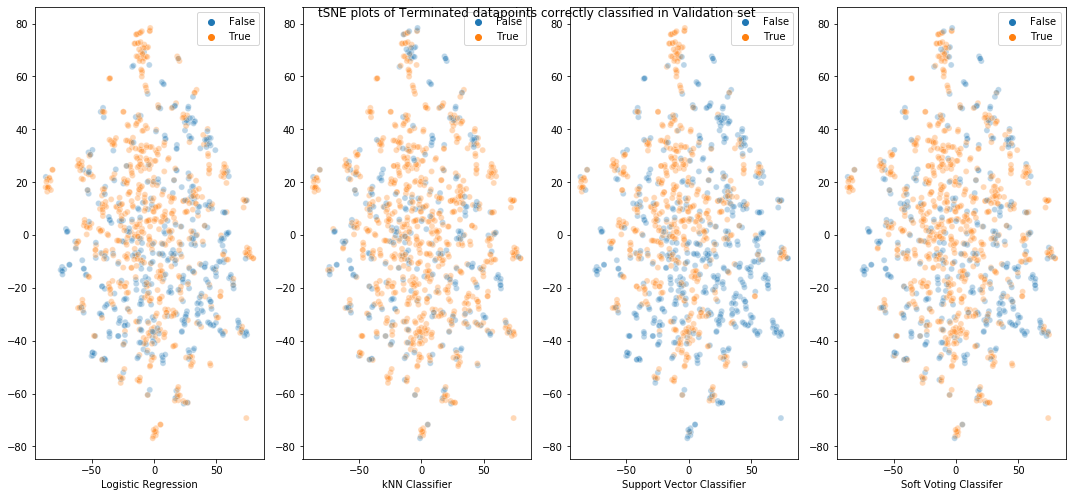

In [354]:
fig, ax = plt.subplots(1,4,figsize=(15,7))

#need to fix this suptitle
fig.suptitle('tSNE plots of Terminated datapoints correctly classified in Validation set')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_lr, alpha = 0.3, ax=ax[0])
ax[0].set_xlabel('Logistic Regression')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_knn, alpha = 0.3, ax=ax[1])

ax[1].set_xlabel('kNN Classifier')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_svc, alpha = 0.3, ax=ax[2])
ax[2].set_xlabel('Support Vector Classifier')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_soft, alpha = 0.3)
ax[3].set_xlabel('Soft Voting Classifer')

plt.tight_layout();



Seems like SVC and LR are producing similar calls on on the Terminated class the same calls, and identifying the same regions of Termianted datapoints. 

I am going to try to make ensembl models with just KNN and LR and see how this changes the metrics. SVC takes a long time to make predictions as well.

# New Soft Voting Classifier with just kNN and LR models

In [205]:
model_names=['knn','lr']

In [206]:
model_vars = [knn, lr]

In [207]:
model_list=list(zip(model_names,model_vars))

In [208]:
average_voting_classifier_2 = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    n_jobs=-1)
average_voting_classifier_2.fit(X_adasyn_cv1, y_adasyn_cv1)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1, voting='soft')

In [209]:
preds_av2=average_voting_classifier_2.predict(X_validate_cv1)

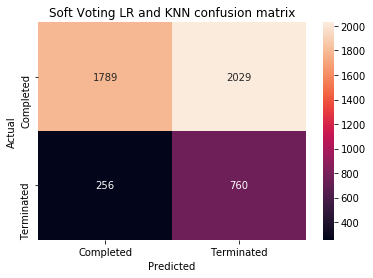

In [210]:
confusion = confusion_matrix(y_validate_cv1, preds_av2)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting LR and KNN confusion matrix');

In [211]:
print(classification_report(y_validate_cv1, preds_av2))

              precision    recall  f1-score   support

   Completed       0.87      0.47      0.61      3818
  Terminated       0.27      0.75      0.40      1016

    accuracy                           0.53      4834
   macro avg       0.57      0.61      0.50      4834
weighted avg       0.75      0.53      0.57      4834



Compared to previous Soft Voting Predictor with KNN, LR and SVC, it retains similar precision, but trades off recall between the two groups. I think this model (LR and KNN) is better, because it is simpler and the increased recall of Terminated is nice

  |       precision|    recall|  f1-score  | support  |
|------------------|----------|------------|----------|
   |Completed      | 0.86     | 0.56   |   0.68   |   3818
  |Terminated  |     0.28  |    0.66   |   0.40    |  1016
 |   accuracy  |         |           |     0.58   |   4834
 |  macro avg   |    0.57   |   0.61   |   0.54   |   4834
|weighted avg   |    0.74   |   0.58   |   0.62    |  4834

In [212]:
F1_list = []
# Will take some time
for i in np.arange(0,1,0.1):
    preds = average_voting_classifier_2.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

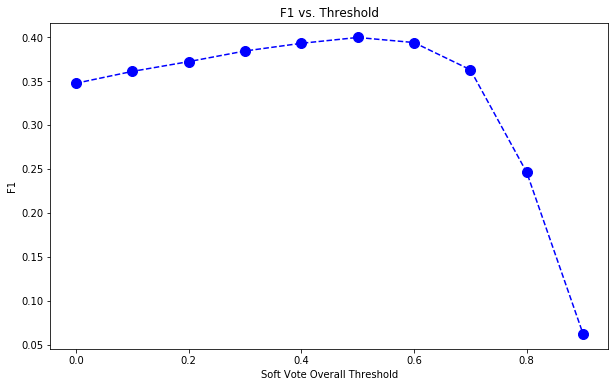

In [213]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.1), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("Soft Vote Overall Threshold")
plt.ylabel("F1")

In [214]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, average_voting_classifier_2.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

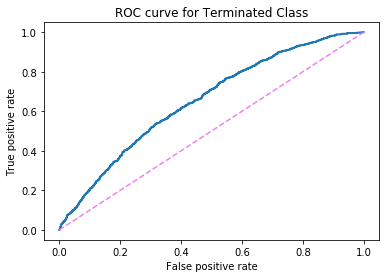

In [215]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [216]:
thresholds[np.argmax(tpr - fpr)]

0.6376115028700731

In [347]:
print(classification_report(y_validate_01, average_voting_classifier_2.predict_proba(X_validate_cv1)[:,1] > 0.6376115028700731))

              precision    recall  f1-score   support

           0       0.85      0.68      0.75      3818
           1       0.31      0.54      0.39      1016

    accuracy                           0.65      4834
   macro avg       0.58      0.61      0.57      4834
weighted avg       0.73      0.65      0.68      4834



In [228]:
print(classification_report(y_validate_01, average_voting_classifier_2.predict_proba(X_validate_cv1)[:,1] > 0.55))

              precision    recall  f1-score   support

           0       0.86      0.54      0.66      3818
           1       0.28      0.66      0.39      1016

    accuracy                           0.56      4834
   macro avg       0.57      0.60      0.52      4834
weighted avg       0.73      0.56      0.60      4834



In [272]:
preds_soft_2=average_voting_classifier_2.predict(X_validate_term)

In [273]:
correct_soft_2 = list(preds_soft_2 == 'Terminated')

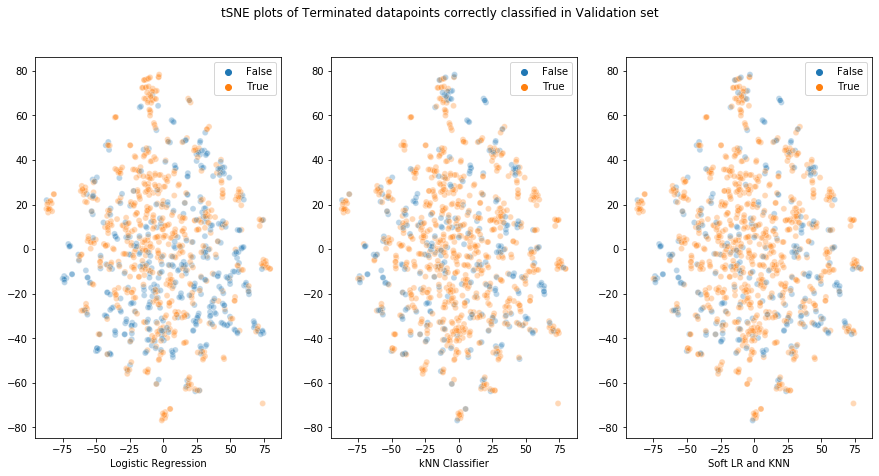

In [350]:
fig, ax = plt.subplots(1,3,figsize=(15,7))

fig.suptitle('tSNE plots of Terminated datapoints correctly classified in Validation set')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_lr, alpha = 0.3, ax=ax[0])
ax[0].set_xlabel('Logistic Regression')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_knn, alpha = 0.3, ax=ax[1])
ax[1].set_xlabel('kNN Classifier')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_soft_2, alpha = 0.3, ax=ax[2])
ax[2].set_xlabel('Soft LR and KNN')

plt.tight_layout;

## Checking model performance on both Phase 3 and Phase 3 trials

In [317]:
with open('coef_names.pickle', 'rb') as read_file:
    columns = pickle.load(read_file)

In [321]:
list(columns).index('Phase 3_design')

96

In [334]:
X_validate_phase3 = X_validate_cv1[X_validate_cv1[:,96] > 0]

In [335]:
y_validate_phase3 = y_validate_cv1[X_validate_cv1[:,96] > 0]

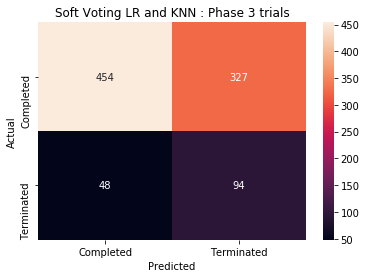

In [336]:
confusion = confusion_matrix(y_validate_phase3, average_voting_classifier_2.predict(X_validate_phase3))
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting LR and KNN : Phase 3 trials');

In [340]:
print(classification_report(y_validate_phase3, average_voting_classifier_2.predict(X_validate_phase3)))

              precision    recall  f1-score   support

   Completed       0.90      0.58      0.71       781
  Terminated       0.22      0.66      0.33       142

    accuracy                           0.59       923
   macro avg       0.56      0.62      0.52       923
weighted avg       0.80      0.59      0.65       923



In [341]:
list(columns).index('Phase 2_design')

94

In [342]:
X_validate_phase2 = X_validate_cv1[X_validate_cv1[:,94] > 0]

In [343]:
y_validate_phase2 = y_validate_cv1[X_validate_cv1[:,94] > 0]

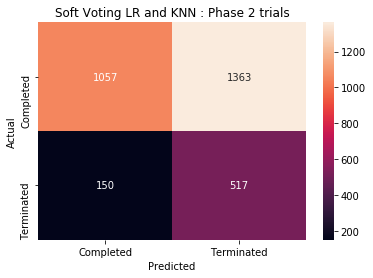

In [345]:
confusion = confusion_matrix(y_validate_phase2, average_voting_classifier_2.predict(X_validate_phase2))
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting LR and KNN : Phase 2 trials');

In [346]:
print(classification_report(y_validate_phase2, average_voting_classifier_2.predict(X_validate_phase2)))

              precision    recall  f1-score   support

   Completed       0.88      0.44      0.58      2420
  Terminated       0.28      0.78      0.41       667

    accuracy                           0.51      3087
   macro avg       0.58      0.61      0.49      3087
weighted avg       0.75      0.51      0.54      3087



# A Hard Voting Classifier with just LR and kNN

LR witll be the one it goes with in a tie since L is further in the alphabet then K

In [105]:
model_names=['lr','knn']

In [240]:
model_vars = [lr, knn]

In [241]:
model_list=list(zip(model_names,model_vars))

In [256]:
voting_classifer = VotingClassifier(estimators=model_list, voting='hard', 
                                    n_jobs=-1)
voting_classifer.fit(X_adasyn_cv1, y_adasyn_cv1)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1)

In [257]:
preds_=voting_classifer.predict(X_validate_cv1)

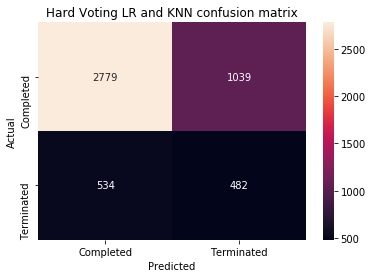

In [258]:
confusion = confusion_matrix(y_validate_cv1, preds_)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Hard Voting LR and KNN confusion matrix');

In [259]:
print(classification_report(y_validate_cv1, preds_))

              precision    recall  f1-score   support

   Completed       0.84      0.73      0.78      3818
  Terminated       0.32      0.47      0.38      1016

    accuracy                           0.67      4834
   macro avg       0.58      0.60      0.58      4834
weighted avg       0.73      0.67      0.70      4834



This is not as good as the soft classifier for Terminated class

Renaming the models so it uses kNN when the models disagree - didn't seem to work !

In [355]:
model_names=['knn','a_lr']

In [363]:
a_lr = lr

In [364]:
model_vars = [knn, a_lr]

In [365]:
model_list=list(zip(model_names,model_vars))

In [366]:
voting_classifer = VotingClassifier(estimators=model_list, voting='hard', 
                                    n_jobs=-1)
voting_classifer.fit(X_adasyn_cv1, y_adasyn_cv1)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('a_lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1)

In [367]:
preds_=voting_classifer.predict(X_validate_cv1)

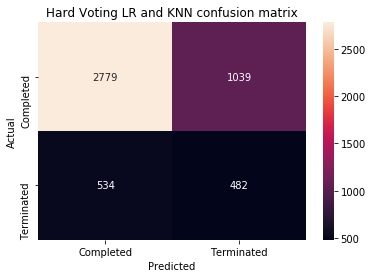

In [368]:
confusion = confusion_matrix(y_validate_cv1, preds_)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Hard Voting LR and KNN confusion matrix');

In [369]:
print(classification_report(y_validate_cv1, preds_))

              precision    recall  f1-score   support

   Completed       0.84      0.73      0.78      3818
  Terminated       0.32      0.47      0.38      1016

    accuracy                           0.67      4834
   macro avg       0.58      0.60      0.58      4834
weighted avg       0.73      0.67      0.70      4834



## Trying XGBoost, KNN and LR together
### An issue I am having is that the ADASYN imputer package required sci-kitlearn 22 and XGBoost package scikitlean 23

I played with soft voting parameters with the pretrained models manually, but couldn't get better than 0.41 F1 score for 'Terminated

In [12]:
preds_gbm=gbm.predict(X_validate_cv1)
preds_lr=lr.predict_proba(X_validate_cv1)[:,1]
preds_knn=knn.predict_proba(X_validate_cv1)[:,1]

In [198]:
vote_pred = (0.8 * preds_gbm + 0.1 *preds_knn + 0.2 *preds_lr) > 0.35

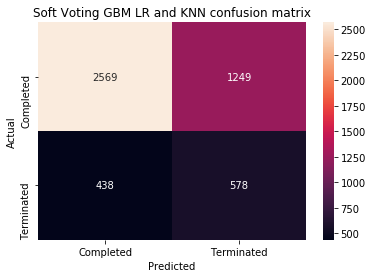

In [199]:
confusion = confusion_matrix(y_validate_01, vote_pred)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting GBM LR and KNN confusion matrix');

In [200]:
print(classification_report(y_validate_01, vote_pred))

              precision    recall  f1-score   support

           0       0.85      0.67      0.75      3818
           1       0.32      0.57      0.41      1016

    accuracy                           0.65      4834
   macro avg       0.59      0.62      0.58      4834
weighted avg       0.74      0.65      0.68      4834



# OK 
## So I am going to go with the Soft Vote KNN and LR combo as my second place model after XGBoost. 
### Training with the full oversampled dataset now

In [371]:
#X_adasyn is the oversampled full training dataset
X_adasyn.shape

(22853, 400)

In [372]:
model_list

[('knn', KNeighborsClassifier(n_neighbors=4, weights='distance')),
 ('a_lr',
  LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=1, max_iter=500,
                     penalty='elasticnet', solver='saga'))]

In [373]:
final_model = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    n_jobs=-1)
final_model.fit(X_adasyn, y_adasyn)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('a_lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1, voting='soft')

In [374]:
with open('final_model.pickle', 'wb') as write_file:
    pickle.dump(final_model, write_file)